In [ ]:
import warnings
warnings.filterwarnings('ignore') 

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
import numpy as np


import pandas as pd

def load_newts(do_min_max=False):
    data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00528/dataset.csv',delimiter=';', header=1)
    xvals_raw = data.drop(['ID', 'Green frogs', 'Brown frogs', 'Common toad', 'Tree frog', 'Common newt', 'Great crested newt', 'Fire-bellied toad'], axis=1)
    xvals = pd.get_dummies(xvals_raw, columns=['Motorway', 'TR', 'VR', 'SUR1', 'SUR2', 'SUR3', 'UR', 'FR', 'MR', 'CR'])
    yvals = data['Fire-bellied toad']

    # optional min-max scaling
    if (do_min_max):
       for col in ['SR', 'NR', 'TR', 'VR', 'OR', 'RR', 'BR']:
           xvals_raw[col] = (xvals_raw[col] - xvals_raw[col].min())/(xvals_raw[col].max() - xvals_raw[col].min())
    xvals = pd.get_dummies(xvals_raw, columns=['Motorway', 'TR', 'VR', 'SUR1', 'SUR2', 'SUR3', 'UR', 'FR', 'MR', 'CR'])
    return xvals, yvals

def eval_kfold_stub(xvals, yvals,classifier,slackIter=True):
    Accuracies=[]
    F1scores=[]
    if slackIter == True:
        lower=0.05
    else:
        lower=1
    # upper=1.001
    # inc=0.002
    # C=0
    upper=10.001
    inc=0.05
    if classifier=="svmrbfSVC":
        lower=0.01
        upper=10.01
        inc=0.01
    for Slack in np.arange(lower, upper, inc):
        kf = KFold(n_splits = 5)
        Acc_thisIter=[]
        f1_thisIter=[]
        for train_idxs, test_idxs in kf.split(xvals):
            xtrain_this_fold = xvals.loc[train_idxs]
            xtest_this_fold = xvals.loc[test_idxs]
            ytrain_this_fold = yvals.loc[train_idxs]
            ytest_this_fold = yvals.loc[test_idxs]
            # train a model on this fold
            # test the model on this fold 
            if classifier == 'linearSVM':
                LinearSVM_acc , f1score = linearSVM(xtrain_this_fold, xtest_this_fold, ytrain_this_fold, ytest_this_fold,Slack)
                Acc_thisIter.append(LinearSVM_acc)
            elif classifier== 'svmrbfSVCwithC' :
                svmSVC_acc , f1score = svmrbfSVC(xtrain_this_fold, xtest_this_fold, ytrain_this_fold, ytest_this_fold,Slack,1)
                Acc_thisIter.append(svmSVC_acc)
            elif classifier== 'svmrbfSVC' :
                svmSVC_acc , f1score = svmrbfSVC(xtrain_this_fold, xtest_this_fold, ytrain_this_fold, ytest_this_fold,1,Slack)
                Acc_thisIter.append(svmSVC_acc)
            f1_thisIter.append(f1score)
        accuracy=sum(Acc_thisIter)/len(Acc_thisIter)
        f1score= sum(f1_thisIter) / len(f1_thisIter)
        Accuracies.append(accuracy)
        F1scores.append(f1score)
    return Accuracies, F1scores


In [ ]:
def linearSVM(X_train,X_test,y_train,y_test,Slack=1):
    LSVCClf = LinearSVC(C=Slack,random_state = 11)
    # LSVCClf = LinearSVC(C=Slack,dual = False, random_state = 0, penalty = 'l1',tol = 1e-5,max_iter=5000)
    LSVCClf.fit(X_train, y_train)
    y_pred = LSVCClf.predict(X_test)    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1score = metrics.f1_score(y_test, y_pred, average= 'weighted')    
    return accuracy , f1score


In [ ]:
# def svmlinearSVC(X_train, X_test, y_train, y_test,Slack=1):
#     clf = svm.SVC(kernel='linear',C=Slack, max_iter=10000000 ) # Linear Kernel
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     return metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred,average= 'weighted')


In [ ]:
def svmrbfSVC(X_train, X_test, y_train, y_test,Slack=1,gamma=1):
    clf = svm.SVC(kernel='rbf',C=Slack,gamma=gamma) 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return metrics.accuracy_score(y_test, y_pred) , metrics.f1_score(y_test, y_pred, average= 'weighted')

In [ ]:
def completeTrainingDataSVM(X,Y,classifier,runSlack=False):
    # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=11)
    accuracy , f1scores= [] , []
    C=0.05
    upper=10.001
    inc=0.05
    if classifier=="svmrbfSVC":
        lower=0.01
        upper=10.01
        inc=0.01
    if classifier == "linearSVM":
        if runSlack==True:
            for Slack in np.arange(C, upper, inc):
                acc,f1=linearSVM(X, X, Y, Y,Slack)
                accuracy.append(acc)
                f1scores.append(f1)
            return accuracy,f1scores
        else:
            acc,f1=linearSVM(X, X, Y, Y)
            return acc, f1
    elif classifier == "svmrbfSVCwithC":
        if runSlack==True:
            for Slack in np.arange(C, upper, inc):
                acc,f1=svmrbfSVC(X, X, Y, Y,Slack,1)
                accuracy.append(acc)
                f1scores.append(f1)
            return accuracy,f1scores
        else:
            acc,f1=svmrbfSVC(X, X, Y, Y)
            return acc, f1
    elif classifier == "svmrbfSVC":
        if runSlack==True:
            for gamma in np.arange(lower, upper, inc):
                acc,f1=svmrbfSVC(X, X, Y, Y, 1,gamma)
                accuracy.append(acc)
                f1scores.append(f1)
            return accuracy,f1scores
        else:
            acc,f1=svmrbfSVC(X, X, Y, Y)
            return acc, f1
    return acc, f1

In [ ]:
X,Y=load_newts(do_min_max=True)
X.shape

(189, 56)

## LinearSVM Accuracies

In [ ]:
import time 
one=time.time()

LinearSVCAcc_TD, LinearSVCf1_TD = completeTrainingDataSVM(X,Y,"linearSVM",True)
LinearSVCAcc_KFD, LinearSVCf1_KFD = eval_kfold_stub(X,Y,"linearSVM")

print("Accuracy on entire training Data : " + str(max(LinearSVCAcc_TD)))
print("F1 on entire training Data : " + str(max(LinearSVCf1_TD)))
print("Accuracy on  KFold Data : "+ str(max(LinearSVCAcc_KFD)))
print("F1 on  KFold Data : "+ str(max(LinearSVCf1_KFD)))

two=time.time()

print(two-one)

Accuracy on entire training Data : 0.8306878306878307
F1 on entire training Data : 0.8190551240196631
Accuracy on  KFold Data : 0.6667140825035561
F1 on  KFold Data : 0.6317012319321318
21.351933240890503


## rbfSVC Accuracies with changing C values 

In [ ]:
import time 
one=time.time()

svmSVCAcc_TD , svmSVCf1_TD = completeTrainingDataSVM(X,Y,"svmrbfSVCwithC",True)
svmSVCAcc_KFD , svmSVCf1_KFD = eval_kfold_stub(X,Y,"svmrbfSVCwithC")

print("Accuracy on entire training Data : " + str(max(svmSVCAcc_TD)))
print("F1 on entire training Data : " + str(max(svmSVCf1_TD)))

print("Accuracy on  KFold Data : "+ str(max(svmSVCAcc_KFD)))
print("F1 on KFold Data : "+ str(max(svmSVCf1_KFD)))


two=time.time()
print(two-one)

Accuracy on entire training Data : 1.0
F1 on entire training Data : 1.0
Accuracy on  KFold Data : 0.6928876244665718
F1 on KFold Data : 0.5709712058427711
12.64090085029602


## rbfKernelSVC Accuracies

In [ ]:
import time 
one=time.time()
rbfSVC_TD, f1scores_TD = completeTrainingDataSVM(X,Y,"svmrbfSVC",True)
rbfSVC_KFD, f1scores_KFD = eval_kfold_stub(X,Y,"svmrbfSVC",True)

print("Accuracy on entire training Data : " + str(max(rbfSVC_TD)))
print("F1 on entire training Data : " + str(max(f1scores_TD)))

print("Accuracy on KFold Data : "+ str(max(rbfSVC_KFD)))
print("F1 on KFold Data : "+ str(max(f1scores_KFD)))
two = time.time()

print(two-one)

Accuracy on entire training Data : 1.0
F1 on entire training Data : 1.0
Accuracy on KFold Data : 0.7036984352773826
F1 on KFold Data : 0.6166446757331474
68.5054190158844


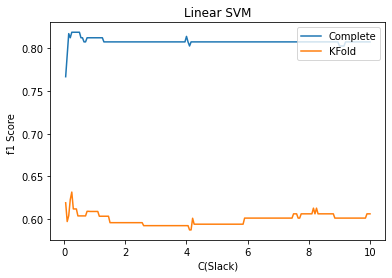

<Figure size 2160x720 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
  
x =  np.arange(0.05, 10.001, 0.05)
y = LinearSVCf1_TD
plt.plot(x, y)
plt.plot(x,LinearSVCf1_KFD)
plt.legend(["Complete", "KFold"], loc ="upper right")
plt.xlabel('C(Slack)')
plt.ylabel('f1 Score ')
plt.title('Linear SVM')
plt.figure(figsize=(30,10))
plt.show()

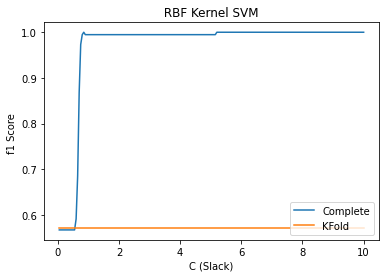

In [ ]:
import matplotlib.pyplot as plt
    
x =  np.arange(0.05, 10.001, 0.05)
y = svmSVCf1_TD
# plt.plot(x, y)
plt.plot(x, y)
plt.plot(x, svmSVCf1_KFD)
plt.legend(["Complete", "KFold"], loc ="lower right")
plt.xlabel('C (Slack)')
plt.ylabel('f1 Score ')
plt.title(' RBF Kernel SVM ')
plt.show()

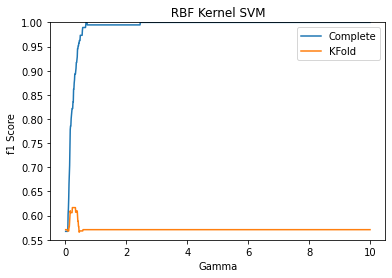

In [ ]:
import matplotlib.pyplot as plt
    
x =  np.arange(0.01, 10.01, 0.01)
y = f1scores_TD
# plt.plot(x, y)
plt.plot(x, y)
plt.plot(x, f1scores_KFD)
plt.legend(["Complete", "KFold"], loc ="upper right")
plt.xlabel('Gamma')
plt.ylabel('f1 Score ')
plt.title(' RBF Kernel SVM ')
plt.ylim(0.55, 1.0)
plt.show()

# Stage 2 : MLP

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

import tensorboard as tf
import keras



In [ ]:
X,Y=load_newts(do_min_max=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=11)
model = Sequential()
model.add(Dense(10, input_dim=56, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
optimizer = keras.optimizers.SGD(lr=0.01)
model.compile(optimizer=optimizer, 
              		loss='binary_crossentropy', 
              		metrics=['accuracy'])
model.fit(X, Y, epochs = 1500,batch_size=10)

loss, acc = model.evaluate(X,Y)
acc

Epoch 1/1500


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 0s 2ms/step - loss: 0.6584 - accuracy: 0.6243
Epoch 2/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6445 - accuracy: 0.6138
Epoch 3/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6369 - accuracy: 0.6402
Epoch 4/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6327 - accuracy: 0.6561
Epoch 5/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6286 - accuracy: 0.6614
Epoch 6/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6250 - accuracy: 0.6508
Epoch 7/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6224 - accuracy: 0.6508
Epoch 8/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6193 - accuracy: 0.6508
Epoch 9/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6166 - accuracy: 0.6508
Epoch 10/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6134 - accuracy: 0.6508
Epoch 11/150

1.0

In [ ]:
X,Y=load_newts(do_min_max=False)
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=11)
model = Sequential()
model.add(Dense(20, input_dim=56, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
optimizer = keras.optimizers.SGD(lr=0.05)
model.compile(optimizer=optimizer, 
              		loss='binary_crossentropy', 
              		metrics=['accuracy'])
model.fit(X, Y, epochs = 1500,batch_size=10)

loss, acc = model.evaluate(X,Y)

acc

Epoch 1/1500


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 1s 2ms/step - loss: 725782.9375 - accuracy: 0.6243
Epoch 2/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.6931
Epoch 3/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6441 - accuracy: 0.6931
Epoch 4/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6345 - accuracy: 0.6931
Epoch 5/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6283 - accuracy: 0.6931
Epoch 6/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6244 - accuracy: 0.6931
Epoch 7/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6218 - accuracy: 0.6931
Epoch 8/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6202 - accuracy: 0.6931
Epoch 9/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6194 - accuracy: 0.6931
Epoch 10/1500
19/19 [==============================] - 0s 2ms/step - loss: 0.6188 - accuracy: 0.6931
Epoch 1

0.6931216716766357

In [ ]:
pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import model_selection
scores = {'accuracy' : make_scorer(accuracy_score), 
           'f1_score' : make_scorer(f1_score, average='weighted')}

from scikeras.wrappers import KerasClassifier
X,Y=load_newts(do_min_max=True)
acc=[]
f1=[]
for i in range(2,30,2):
  model = Sequential()
  model.add(Dense(i,input_dim=56, activation = 'sigmoid'))
  # model.add(Dense(i, activation='sigmoid'))
  model.add(Dense(1, activation='sigmoid'))
  optimizer = keras.optimizers.SGD(lr=0.01)
  model.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
  # model.fit(X_train, y_train, epochs = 1500)
  est=KerasClassifier(model=model, epochs=1000, batch_size=5, verbose=1)
  kfold = KFold(n_splits=5, shuffle=True)
  results = model_selection.cross_validate(est, X, Y, cv=kfold, scoring=scores)
  # accuracy = cross_val_score(est, X, Y, cv=kfold)
  acc.append(results)
  print(results)



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
31/31 [==============================] - 0s 3ms/step - loss: 0.3381 - accuracy: 0.8874
Epoch 504/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.3378 - accuracy: 0.8874
Epoch 505/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.3374 - accuracy: 0.8874
Epoch 506/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.3373 - accuracy: 0.8874
Epoch 507/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.3370 - accuracy: 0.8874
Epoch 508/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.3370 - accuracy: 0.8874
Epoch 509/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.3370 - accuracy: 0.8940
Epoch 510/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.3366 - accuracy: 0.8874
Epoch 511/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.3362 - accuracy: 0.8874
Epoch 512/1000
31/31 [========================

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/1000
31/31 [==============================] - 1s 3ms/step - loss: 0.7331 - accuracy: 0.4106
Epoch 2/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.4768
Epoch 3/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.5762
Epoch 4/1000
31/31 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.6026
Epoch 5/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6424
Epoch 6/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6424
Epoch 7/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6556
Epoch 8/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6689
Epoch 9/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6689
Epoch 10/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6689

In [ ]:
acc

[{'fit_time': array([123.34527493, 133.33070469, 126.95482969, 142.78433228,
         142.56808591]),
  'score_time': array([0.12840414, 0.15072608, 0.17692089, 0.15976644, 0.15715241]),
  'test_accuracy': array([0.55263158, 0.63157895, 0.68421053, 0.68421053, 0.7027027 ]),
  'test_f1_score': array([0.37037037, 0.22222222, 0.25      , 0.5       , 0.52173913])},
 {'fit_time': array([142.53832269, 142.56501079, 142.53579974, 142.53147435,
         142.49900937]),
  'score_time': array([0.16806602, 0.19687414, 0.15531778, 0.15934587, 0.15930653]),
  'test_accuracy': array([0.73684211, 0.63157895, 0.63157895, 0.73684211, 0.67567568]),
  'test_f1_score': array([0.58333333, 0.46153846, 0.36363636, 0.54545455, 0.57142857])},
 {'fit_time': array([142.51114726, 127.60618186, 127.98386407, 128.53438354,
         142.48664808]),
  'score_time': array([0.15996504, 0.16944838, 0.16623449, 0.16091824, 0.12082386]),
  'test_accuracy': array([0.63157895, 0.68421053, 0.57894737, 0.52631579, 0.75675676]

In [ ]:
accuracy = [np.mean(i['test_accuracy']) for i in acc]
accuracy

[0.6510668563300142,
 0.6825035561877666,
 0.6355618776671408,
 0.6458036984352773,
 0.6405405405405405,
 0.6352773826458037,
 0.602560455192034,
 0.6081081081081081,
 0.6615931721194879,
 0.6140825035561879,
 0.6561877667140825,
 0.6347083926031295,
 0.6082503556187767,
 0.5978662873399716]

In [ ]:
f1_score = [np.mean(i['test_f1_score']) for i in acc]
f1_score

[0.3728663446054751,
 0.5050782550782551,
 0.403017168589924,
 0.39389809063722103,
 0.40434782608695646,
 0.4242424242424242,
 0.33594698377307075,
 0.3735902031063322,
 0.36465097835867555,
 0.38465608465608464,
 0.4258333333333333,
 0.40736190346385237,
 0.35279052331683913,
 0.3115438596491228]

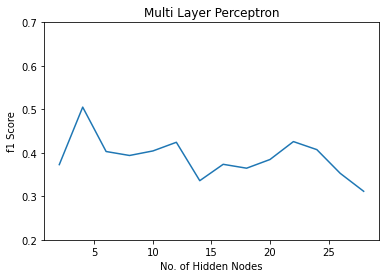

In [ ]:
import matplotlib.pyplot as plt
    
x =  np.arange(2, 30, 2)
y = f1_score
# plt.plot(x, y)
plt.plot(x, y)
plt.xlabel('No. of Hidden Nodes')
plt.ylabel('f1 Score')
plt.title('Multi Layer Perceptron')
plt.ylim(0.2, 0.7)

plt.show()